#European Option Class for pricing in Python
****
## About this notebook: 
Notebook prepared by **Jesus Perez Colino** Version 0.1, First Released: 21/03/2011, Alpha

- This work is licensed under a [Creative Commons Attribution-ShareAlike 3.0 Unported License](http://creativecommons.org/licenses/by-sa/3.0/deed.en_US). This work is offered for free, with the hope that it will be useful.


- **Summary**: This notebook is just the simplest implementation of an abstract class for the European option pricing in three different methods (TODO: will be extended soon to FFT and PDEs)


- **Python & packages versions** to reproduce the results of this notebook: 

In [1]:
import numpy as np
import IPython
from scipy.stats import norm
from abc import ABCMeta, abstractmethod
from sys import version 
print ' Reproducibility conditions for this notebook '.center(85,'-')
print 'Python version:     ' + version
print 'Numpy version:      ' + np.__version__
print 'IPython version:    ' + IPython.__version__
print '-'*85

-------------------- Reproducibility conditions for this notebook -------------------
Python version:     2.7.10 |Anaconda 2.3.0 (x86_64)| (default, May 28 2015, 17:04:42) 
[GCC 4.2.1 (Apple Inc. build 5577)]
Numpy version:      1.9.2
IPython version:    3.2.1
-------------------------------------------------------------------------------------


In [2]:
class EuropeanOption(object):
    """ Abstract Class for European options. Partially implemented.
    S0 : float : initial stock/index level
    strike : float : strike price
    T : float : time to maturity (in year fractions)
    r : float : constant risk-free short rate
    div :    float : dividend yield
    sigma :  float : volatility factor in diffusion term
    simulations: int: number of simulations for MonteCarlo"""

    __metaclass__ = ABCMeta

    def __init__(self, option_type, S0, strike, T, r, div, sigma, model):
        try:
            self.option_type = option_type
            assert isinstance(option_type, str)
            self.S0 = float(S0)
            self.strike = float(strike)
            self.T = float(T)
            self.r = float(r)
            self.div = float(div)
            self.sigma = float(sigma)
            self.model = str(model)
        except ValueError:
            print('Error passing Options parameters')

        models = ['BlackScholes', 'MonteCarlo', 'BinomialTree', 'FFT', 'PDE']
        if model not in models:
            raise Exception('Error: Model unknown')
        option_types = ['call', 'put']
        if option_type not in option_types:
            raise ValueError("Error: Option type not valid. Enter 'call' or 'put'")
        if S0 < 0 or strike < 0 or T <= 0 or r < 0 or div < 0 or sigma < 0:
            raise ValueError('Error: Negative inputs not allowed')

    def getmodel(self):
        return self.model

    def __str__(self):
        return "This European Option is priced using {0}".format(self.model)

    @abstractmethod
    def value(self):
        pass
        
    @abstractmethod
    def delta(self):
        pass

    @abstractmethod
    def gamma(self):
        pass

    @abstractmethod
    def vega(self):
        pass

    @abstractmethod
    def rho(self):
        pass
    
    @abstractmethod
    def theta(self):
        pass
    

In [3]:
class BlackScholes(EuropeanOption):

    def __init__(self, option_type, S0, strike, T, r, div, sigma):
        EuropeanOption.__init__(self,option_type, S0, strike, 
                                T, r, div, sigma, 'BlackScholes')
        
        d1 = float((np.log(self.S0 / self.strike) + 
              (self.r - self.div + 0.5 * self.sigma ** 2) * self.T) / 
              float( self.sigma * np.sqrt(self.T)))
        d2 = float(d1 - self.sigma * np.sqrt(self.T))

        self.Nd1 = norm.cdf(d1, 0, 1)
        self.Nnd1 = norm.cdf(-d1, 0, 1)
        self.Nd2 = norm.cdf(d2, 0, 1)
        self.Nnd2 = norm.cdf(-d2, 0, 1)

    @property
    def value(self):
        if self.option_type == 'call':
            value = (self.S0 * np.exp(-self.div * self.T) * self.Nd1 -
                     self.strike * np.exp(-self.r * self.T) * self.Nd2)
        else:
            value = (self.strike * np.exp(-self.r * self.T) * self.Nnd2 -
                     self.S0 * np.exp(-self.div * self.T) * self.Nnd1)
        return value
    
    @property
    def delta(self):
        if self.option_type == 'call':
            delta = np.exp( - self.div * self.T) * self.Nd1
        else:
            delta = np.exp( - self.div * self.T) * (self.Nd1 - 1)
        return delta
    
    @property
    def vega(self):
        vega = self.S0 * self.Nd1 * np.exp(- self.div * self.T) * np.sqrt(self.T)
        return vega
    
    @property
    def gamma(self):
        gamma = (self.Nd1 * np.exp(-self.div * self.T) / 
                 float(self.S0 * self.sigma * np.sqrt(self.T)))
        return gamma

    @property
    def rho(self):
        if self.option_type == 'call':
            rho = self.strike * self.T * np.exp(-self.r * self.T) * self.Nd2
        else:
            rho = - self.strike * self.T * np.exp(-self.r * self.T) * self.Nnd2
        return rho
    
    @property
    def theta(self):
        if self.option_type == 'call':
            theta = ((- self.S0 * self.Nd1 * self.sigma * np.exp(- self.div * self.T)) / 
                     float(2. * np.sqrt(self.T)) + 
                     self.div * self.S0 * self.Nd1 * np.exp(- self.div * self.T) - 
                     self.r * self.strike * np.exp(- self.r * self.T) * self.Nd2)
        else:
            theta = ((self.S0 * self.Nd1 * self.sigma * np.exp(- self.div * self.T)) /
                     float(2. * np.sqrt(self.T)) + 
                     self.div * self.S0 * self.Nnd1 * np.exp(- self.div * self.T) - 
                     self.r * self.strike * np.exp(- self.r * self.T) * self.Nnd2)
        return theta

In [4]:
class MonteCarlo(EuropeanOption):

    def __init__(self, option_type, S0, strike, T, r, div, sigma, simulations = 100000):
        EuropeanOption.__init__(self, option_type, S0, strike, 
                                T, r, div, sigma, "MonteCarlo")
        self.simulations = int(simulations)
        try:
            if self.simulations > 0 :
                assert isinstance(self.simulations, int)
        except:
            raise ValueError("Simulation's number has to be positive integer")

    def generate_payoffs(self):
        brownian = np.random.normal(size = self.simulations)
        price_terminal = self.S0 * np.exp((self.r - self.div - 0.5 * self.sigma ** 2) * self.T +
                                          self.sigma * np.sqrt(self.T) * brownian)
        if self.option_type == 'call':
            payoff = np.maximum((price_terminal - self.strike), np.zeros(self.simulations))
        else:
            payoff = np.maximum((self.strike - price_terminal), np.zeros(self.simulations))
        return payoff

    @property
    def value(self):
        payoff = self.generate_payoffs()
        return np.exp(-1.0 * self.r * self.T) * np.sum(payoff) / float(self.simulations)
      
    @property
    def delta(self): # TODO
        pass

    @property
    def gamma(self): # TODO
        pass

    @property
    def vega(self): # TODO
        pass

    @property
    def rho(self): # TODO
        pass
    
    @property
    def theta(self): # TODO
        pass

In [5]:
class BinomialTree(EuropeanOption):
    def __init__(self, option_type, S0, strike, T, r, div, sigma, time_grid ):
        EuropeanOption.__init__(self, option_type, S0, strike, 
                                T, r, div, sigma, "BinomialTree")
        self.time_grid = int(time_grid)
        if self.time_grid <= 0 :
            raise ValueError("Error: Number of time steps has to be positive integer")
    
    @property
    def value(self):
        delta_time = self.T / self.time_grid    
        discount = np.exp(-self.r * delta_time)
        move_up = np.exp(self.sigma * np.sqrt(delta_time))
        move_down = 1 / float(move_up)
        probability = (np.exp(self.r * delta_time) - move_down) / float(move_up - move_down)
        index_up = np.arange(self.time_grid + 1)
        index_up = np.resize(index_up, (self.time_grid + 1, self.time_grid + 1))
        index_down = np.transpose(index_up)
        index_up = move_up ** (index_up - index_down)
        index_down = move_down ** index_down
        S = self.S0 * index_up * index_down
        if self.option_type == 'call':
            V = np.maximum(S - self.strike, 0)  
        else:
            V = np.maximum(self.strike - S, 0)   
        z=0
        for t in range(self.time_grid - 1, -1, -1): 
            V[0:self.time_grid - z, t] = (( probability * 
                                           V[0:self.time_grid - z, t + 1] + 
                                           (1 - probability) * 
                                           V[1:self.time_grid - z + 1, t + 1] ) *
                                          discount)
            z += 1
        return V[0,0]
    
    @property
    def delta(self):# TODO
        pass

    @property
    def gamma(self):# TODO
        pass

    @property
    def vega(self):# TODO
        pass

    @property
    def rho(self):# TODO
        pass
    
    @property
    def theta(self): # TODO
        pass


In [6]:
myCall = BlackScholes('call', 100., 100., .5, 0., 0., .35)
print myCall
print 'Price: ', myCall.value
print 'Delta: ', myCall.delta
print 'Gamma: ', myCall.gamma
print 'Vega:  ', myCall.vega
print 'Rho:   ', myCall.rho
print 'Theta: ', myCall.theta

This European Option is priced using BlackScholes
Price:  9.84817795274
Delta:  0.549240889764
Gamma:  0.0221926832947
Vega:   38.8371957657
Rho:    22.5379555118
Theta:  -13.593018518


In [7]:
myCall = BinomialTree('call', 100, 100, .5, 0., 0., 0.35, 252)
print myCall
print myCall.value

This European Option is priced using BinomialTree
9.8384129573


In [8]:
myCall = MonteCarlo('call', 100, 100, .5, 0, 0, 0.35)
print myCall
print myCall.value

This European Option is priced using MonteCarlo
9.94738498208


*****
### 3D Plotting
*****

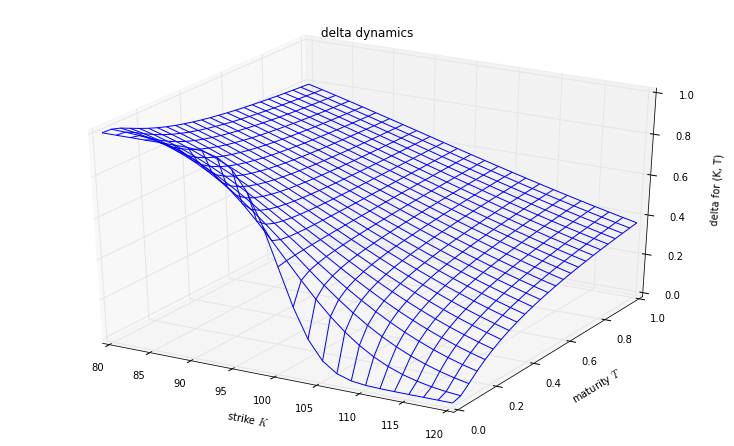

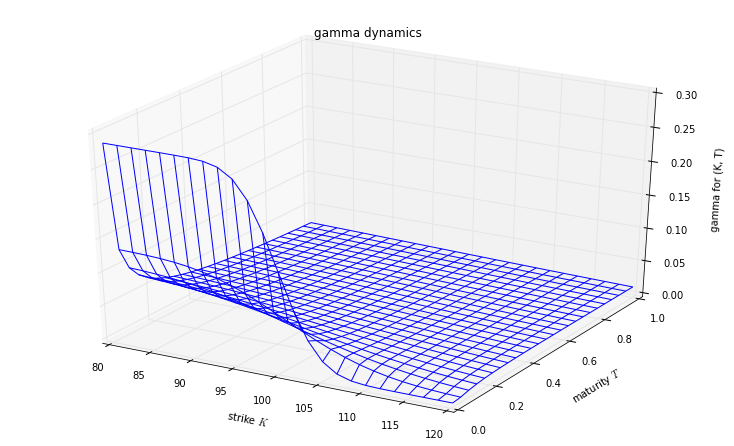

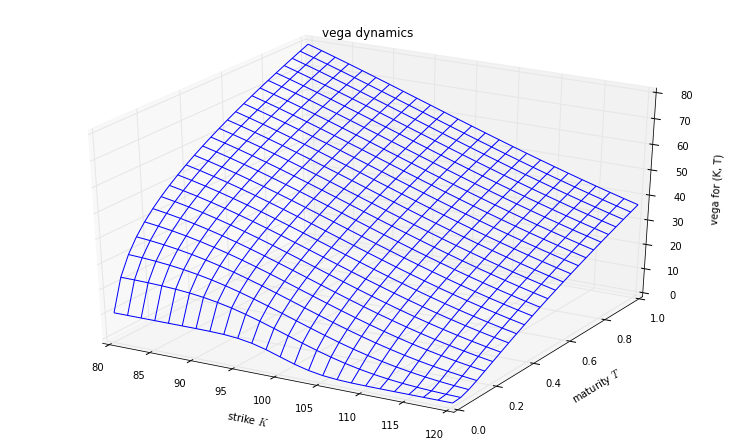

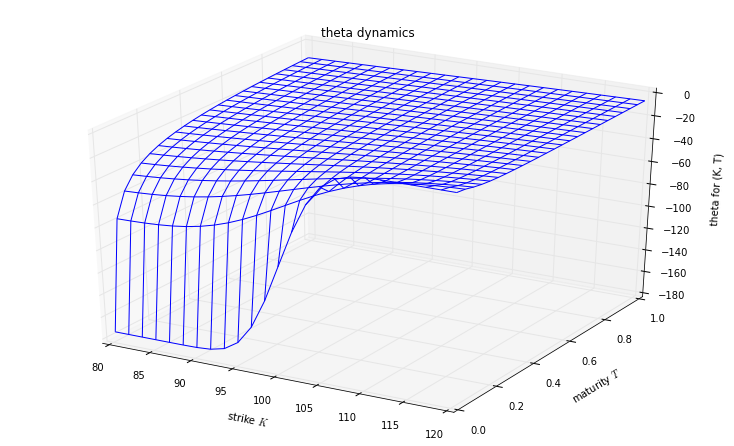

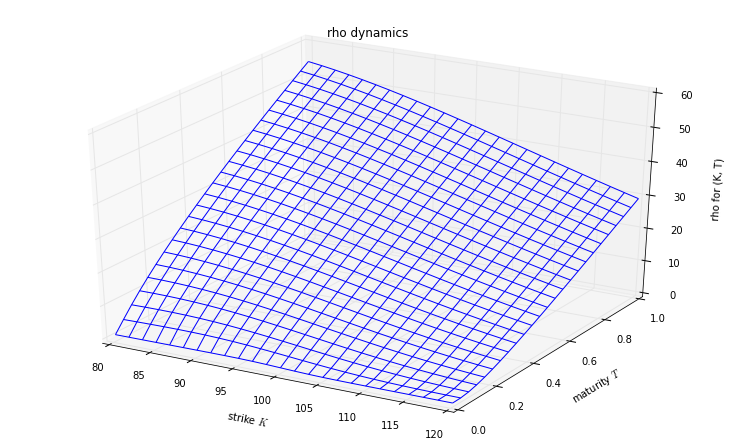

In [21]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import rcParams

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150

greeks = ['delta', 'gamma', 'vega', 'theta', 'rho']
maturities = np.linspace(0.01, 1, 25)
strikes = np.linspace(80, 120, 25)
value = np.zeros((len(maturities), len(strikes)), dtype=np.float)
for greek in greeks: 
    for j in range(len(strikes)):
        for i in range(len(maturities)):
            myCall = BlackScholes('call', 100., strikes[j], maturities[i], 0., 0., .35)
            value[i,j] = eval('myCall.{0}'.format(greek))

    x, y = np.meshgrid(strikes, maturities)
    myfigure = plt.figure()
    plot = p3.Axes3D(myfigure)
    plot.plot_wireframe(x, y, value)
    plot.set_title('{0} dynamics'.format(greek), fontdict=None, loc=u'center')
    plot.set_xlabel('strike $K$')
    plot.set_ylabel('maturity $T$')
    plot.set_zlabel('%s for (K, T)' % greek)